In [1]:
import pandas as pd
from pathlib import Path
import json

results_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/results/gpt2_simulation/all_at_once"
results = dict()
for fname in Path(results_dir).iterdir():
    with open(fname, "r") as f:
        r = json.load(f)
    last = fname.stem.split(".")[-1]
    layer = int(last.split("_")[0])
    feat = int(last[last.index("_feature") + len("_feature"):])
    results[fname.stem] = {"ev_correlation_score": r["ev_correlation_score"], "layer": layer, "feature": feat}
results_df = pd.DataFrame(results).T
results_df["layer"] = results_df["layer"].astype(int)
results_df["feature"] = results_df["feature"].astype(int)
results_df = results_df.sort_values("ev_correlation_score", ascending=False)
unq_layers = results_df["layer"].unique()
results_df

,ev_correlation_score,layer,feature
.transformer.h.2_feature0,0.970093,2,0
.transformer.h.2_feature19,0.966378,2,19
.transformer.h.0_feature0,0.952401,0,0
.transformer.h.4_feature4,0.952061,4,4
.transformer.h.0_feature5,0.949993,0,5
.transformer.h.2_feature4,0.941871,2,4
.transformer.h.2_feature11,0.930066,2,11
.transformer.h.4_feature19,0.918787,4,19
.transformer.h.0_feature14,0.906342,0,14
.transformer.h.0_feature3,0.897080,0,3


In [2]:
from nnsight import LanguageModel

# Load the GPT-2 model
# dispatch=True is necessary to load the weights
model = LanguageModel('openai-community/gpt2', device_map='cuda', dispatch=True)

/home/alex/.conda/envs/autointerp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from collections import Counter, defaultdict
import random
import json

with open("pile.jsonl", "r") as f:
    pile = [json.loads(line) for line in f.readlines()]

In [4]:
from tqdm import tqdm
import torch

n_samples = 5000
sample_texts = [s["text"] for s in random.sample(pile, n_samples)]
freqs = defaultdict(int)
for text in tqdm(sample_texts):
    tok_ids = model.tokenizer.encode(text, add_special_tokens=False)
    for tok_id in tok_ids:
        freqs[tok_id] += 1
unigram_p = torch.zeros(model.tokenizer.vocab_size, device="cuda:0")
total = sum(freqs.values())
for tok_id, freq in freqs.items():
    unigram_p[tok_id] = freq / total
unigram_p.sum()


100%|██████████| 5000/5000 [00:17<00:00, 279.74it/s]


tensor(1., device='cuda:0')

In [5]:
del pile
unigram_p

tensor([4.1973e-04, 1.8643e-03, 9.3495e-04,  ..., 7.8832e-07, 5.6309e-07,
        0.0000e+00], device='cuda:0')

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

explainer_name = "meta-llama/Meta-Llama-3-8B"
explainer = AutoModelForCausalLM.from_pretrained(explainer_name).to(torch.bfloat16).to("cuda:0")
explainer_tokenizer = AutoTokenizer.from_pretrained(explainer_name)
explainer_tokenizer.pad_token = explainer_tokenizer.eos_token
explainer_tokenizer.pad_token_id = explainer_tokenizer.eos_token_id
explainer.generation_config.pad_token_id = explainer_tokenizer.eos_token_id
explainer.config.pad_token_id = explainer_tokenizer.eos_token_id

# NOTE: scorer is explainer for now, to save space
scorer = explainer
scorer_tokenizer = explainer_tokenizer

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
def get_explainer_prompt(tokens, logit_contributions, few_shot_tokens_lists=None, few_shot_logit_contributions_lists=None, few_shot_explanations=None, logits_prompt_scale=1.0):
    
    if few_shot_tokens_lists is not None:
        assert few_shot_logit_contributions_lists is not None and few_shot_explanations is not None
        assert len(few_shot_tokens_lists) == len(few_shot_logit_contributions_lists) == len(few_shot_explanations)
        few_shot_prompt = "\n\n".join(get_explainer_prompt(toks, logits, logits_prompt_scale=logits_prompt_scale) + f" {expl.strip()}" for toks, logits, expl in zip(few_shot_tokens_lists, few_shot_logit_contributions_lists, few_shot_explanations)) + "\n\n"
    else:
        few_shot_prompt = ""
    tokens_str = ", ".join(f"'{tok}' (+{round(logit * logits_prompt_scale)})" for tok, logit in zip(tokens, logit_contributions))
    return few_shot_prompt + f"Tokens: {tokens_str}\nExplanation:"

def get_scorer_simplicity_prompt(explanation):
    prefix = "Explanation\n\n"
    return f"{prefix}{explanation}{scorer_tokenizer.eos_token}", prefix

def get_scorer_predictiveness_prompt(explanation, few_shot_explanations=None, few_shot_tokens=None):
    if few_shot_explanations is not None:
        assert few_shot_tokens is not None
        assert len(few_shot_explanations) == len(few_shot_tokens)
        few_shot_prompt = "'\n\n".join(get_scorer_predictiveness_prompt(explanation) + token for explanation, token in zip(few_shot_explanations, few_shot_tokens)) + "'\n\n"
    else:
        few_shot_prompt = ""
    return few_shot_prompt + f"Explanation: {explanation}\nSample: '"

few_shot_tokens_lists = [[" Apples", "BASKET", " orange", " Salad", " rosemary", " far", "Field"],
                         ["ateg", " vulnerabilities", "agame", " geek", "arily", " eclectic", " mole", "WAY", " angle", " Warcraft"],
                         [" she", " her", " hers", " she's", " Her", " She", " Ms.", " maj"]]
few_shot_logit_contributions_lists = [[10, 8, 8, 4, 3, 3, 3],
                                    [5, 5, 4, 4, 4, 4, 4, 4, 4, 4],
                                    [11, 10, 10, 7, 5, 3, 3, 2]]
few_shot_explanations = ["fruits and vegetables", "ateg", "she/her pronouns"]
print(get_explainer_prompt(few_shot_tokens_lists[0], few_shot_logit_contributions_lists[0], few_shot_tokens_lists, few_shot_logit_contributions_lists, few_shot_explanations))

few_shot_tokens = [" Oranges", "WAY", " hers"]
print(get_scorer_predictiveness_prompt(few_shot_explanations[0], few_shot_explanations, few_shot_tokens))

Tokens: ' Apples' (+10), 'BASKET' (+8), ' orange' (+8), ' Salad' (+4), ' rosemary' (+3), ' far' (+3), 'Field' (+3)
Explanation: fruits and vegetables

Tokens: 'ateg' (+5), ' vulnerabilities' (+5), 'agame' (+4), ' geek' (+4), 'arily' (+4), ' eclectic' (+4), ' mole' (+4), 'WAY' (+4), ' angle' (+4), ' Warcraft' (+4)
Explanation: ateg

Tokens: ' she' (+11), ' her' (+10), ' hers' (+10), ' she's' (+7), ' Her' (+5), ' She' (+3), ' Ms.' (+3), ' maj' (+2)
Explanation: she/her pronouns

Tokens: ' Apples' (+10), 'BASKET' (+8), ' orange' (+8), ' Salad' (+4), ' rosemary' (+3), ' far' (+3), 'Field' (+3)
Explanation:
Explanation: fruits and vegetables
Sample: ' Oranges'

Explanation: ateg
Sample: 'WAY'

Explanation: she/her pronouns
Sample: ' hers'

Explanation: fruits and vegetables
Sample: '


In [9]:
from sae_auto_interp.autoencoders import load_oai_autoencoders
from tqdm import tqdm
from collections import Counter

k = 10
logits_prompt_scale = 10

lm_head = model.lm_head
aes = load_oai_autoencoders(model, unq_layers.tolist(), "/mnt/ssd-1/gpaulo/SAE-Zoology/weights/gpt2_128k")

In [10]:
def get_scores(feat, layer):
    # simple logit lens without accounting for layer norm
    with torch.inference_mode():
        feat = feat / feat.norm()
        for l in range(layer + 1, len(model.transformer.h)):
            # feat = model.transformer.h[l].ln_1.weight * feat  # only ln2 is applied to the residual stream
            feat = model.transformer.h[l].ln_2.weight * feat
            # the weight changes direction and the norm (it's a diagonal transformation)
            # but we don't care about the norm, so we normalize it for numerical stability
            feat = feat / feat.norm()  
        logit_contributions = lm_head.weight.data @ feat


    top_logits = logit_contributions.topk(k)
    # bottom_logits = logit_contributions.topk(k, largest=False)
    top_tokens = [model.tokenizer.decode(tok) for tok in top_logits.indices]
    print(get_explainer_prompt(top_tokens, top_logits.values.tolist(), logits_prompt_scale=logits_prompt_scale))

    # get explanation
    explainer_prompt = get_explainer_prompt(top_tokens, top_logits.values.tolist(), few_shot_tokens_lists, few_shot_logit_contributions_lists, few_shot_explanations, logits_prompt_scale=logits_prompt_scale)
    explainer_input_ids = explainer_tokenizer(explainer_prompt, return_tensors="pt").input_ids.to("cuda:0")
    with torch.inference_mode():  # TODO: cache the few-shot prompt
        samples = explainer.generate(explainer_input_ids, max_new_tokens=100, eos_token_id=explainer_tokenizer.encode("\n\n")[-1], num_return_sequences=10)[:, explainer_input_ids.shape[1]:]

    explanations = Counter([explainer_tokenizer.decode(sample).split("\n\n")[0].strip() for sample in samples])
    explanation = explanations.most_common(1)[0][0]

    # get the explanation simplicity
    simplicity_prompt, simplicity_prompt_prefix = get_scorer_simplicity_prompt(explanation)
    simplicity_prefix_input_ids = scorer_tokenizer(simplicity_prompt_prefix, return_tensors="pt").input_ids.to("cuda:0")
    simplicity_explanation_input_ids = scorer_tokenizer(simplicity_prompt[len(simplicity_prompt_prefix):], return_tensors="pt", add_special_tokens=False).input_ids.to("cuda:0")
    simplicity_input_ids = torch.cat([simplicity_prefix_input_ids, simplicity_explanation_input_ids], dim=1)
    with torch.inference_mode():
        # the loss is averaged over the sequence length, so we need to scale it back
        labels = simplicity_input_ids.clone()
        labels[:, :len(simplicity_prefix_input_ids)] = -100
        logp_explanation = -scorer(simplicity_input_ids, labels=labels).loss * simplicity_explanation_input_ids.shape[1]

    # get the explanation predictiveness
    scorer_predictiveness_prompt = get_scorer_predictiveness_prompt(explanation, few_shot_explanations, few_shot_tokens)
    scorer_input_ids = scorer_tokenizer(scorer_predictiveness_prompt, return_tensors="pt").input_ids.to("cuda:0")
    with torch.inference_mode():
        scorer_logits = scorer(scorer_input_ids).logits[0, -1, :]
        scorer_logp = scorer_logits.log_softmax(dim=-1)

    # here is where we assume that the "clean" output distribution is uniform, 
    # so that the intervened distribtion is entirely determined by the logit contributions and the intervention strength (equivalent to 1/temperature)
    predictiveness_scores = []
    max_intervened_probs = []
    for intervention_strength in intervention_strengths:
        intervened_probs = (logit_contributions * intervention_strength + unigram_p.log()).softmax(dim=-1)
        max_intervened_probs.append(max(intervened_probs).item())


        scorer_vocab = scorer_tokenizer.vocab  # for some reason this takes 34 ms so we need to factor it out
        predictiveness_score = torch.tensor(0.0, device="cuda:0")
        for subj_tok, subj_id in model.tokenizer.vocab.items():
            if subj_tok in scorer_vocab:
                scorer_tok = subj_tok
            else:
                # we need to map the subject model's tokens to the scorer model token that has the longest common prefix
                for i in range(len(subj_tok) - 1, 0, -1):
                    if subj_tok[:i] in scorer_vocab:
                        scorer_tok = subj_tok[:i]
                        break
                else:
                    raise ValueError(f"No scorer token found for {subj_tok}")
            predictiveness_score += intervened_probs[subj_id] * scorer_logp[scorer_vocab[scorer_tok]]
        
        predictiveness_scores.append(predictiveness_score.item())
    
    predictiveness_score = sum(predictiveness_scores) / len(predictiveness_scores)

    return {
        "predictiveness_score": predictiveness_score,
        "simplicity_score": logp_explanation.item(),
        "score": (predictiveness_score + logp_explanation).item(),
        "explanation": explanation,
        "top_tokens": top_tokens,
        "top_logits": top_logits.values.tolist(),
        "max_intervened_probs": max_intervened_probs,
        "predictiveness_scores": predictiveness_scores,
        "intervention_strengths": intervention_strengths,
    }

# Intervention strength is equivalent to 1/temperature
# tuned so that top tokens have a reasonable probability
# If this is too high, it's just the argmax and then every feature trivially can get a high score (expl = argmax)
# If this is too low, it's a uniform output distribution and every feature gets roughly the same score
intervention_strengths = [3, 10, 32, 100, 320]
results = []
for row in tqdm(results_df.iloc, total=len(results_df)):
    feat = aes[f".transformer.h.{int(row['layer'])}"].ae.ae.decoder.weight.data[:, int(row['feature'])]
    result = get_scores(feat, int(row['layer']))
    print(f"layer: {row['layer']}, feature: {row['feature']}, score: {result['score']}, explanation: {result['explanation']}, predictiveness_score: {result['predictiveness_score']}, simplicity_score: {result['simplicity_score']}")
    results.append({
        **result,
        **row.to_dict()
    })

  0%|          | 0/43 [00:00<?, ?it/s]

Tokens: ' acknow' (+9), 'iscons' (+9), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), ' showc' (+9)
Explanation:


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
  2%|▏         | 1/43 [00:09<06:29,  9.28s/it]

layer: 2.0, feature: 0.0, score: -43.077545166015625, explanation: acknow, predictiveness_score: -15.30282211303711, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+9), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'lehem' (+9), 'Buyable' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


  5%|▍         | 2/43 [00:17<06:06,  8.95s/it]

layer: 2.0, feature: 19.0, score: -43.0294189453125, explanation: acknow, predictiveness_score: -15.254693031311035, simplicity_score: -27.77472496032715
Tokens: ' the' (+9), ',' (+9), '-' (+8), ' and' (+8), '.' (+8), ' a' (+8), '
' (+8), ' in' (+7), ' "' (+7), ' (' (+7)
Explanation:


  7%|▋         | 3/43 [00:30<06:59, 10.48s/it]

layer: 0.0, feature: 0.0, score: -26.621410369873047, explanation: the, predictiveness_score: -8.606150817871093, simplicity_score: -18.0152587890625
Tokens: ' the' (+9), ' a' (+8), ',' (+8), ' "' (+7), ' and' (+7), '-' (+7), '
' (+7), '.' (+7), ' in' (+7), ' (' (+6)
Explanation:


  9%|▉         | 4/43 [00:42<07:15, 11.18s/it]

layer: 4.0, feature: 4.0, score: -22.36276626586914, explanation: the, predictiveness_score: -4.347506976127624, simplicity_score: -18.0152587890625
Tokens: ' acknow' (+10), 'iscons' (+10), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), ' Yanuk' (+9), 'lehem' (+9), 'ngth' (+9)
Explanation:


 12%|█▏        | 5/43 [00:51<06:30, 10.29s/it]

layer: 0.0, feature: 5.0, score: -45.819496154785156, explanation: Azerb, predictiveness_score: -15.66209602355957, simplicity_score: -30.15740203857422
Tokens: ' acknow' (+10), 'iscons' (+9), ' Azerb' (+9), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 14%|█▍        | 6/43 [00:59<06:00,  9.75s/it]

layer: 2.0, feature: 4.0, score: -42.97443389892578, explanation: acknow, predictiveness_score: -15.199707221984863, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+9), ' Azerb' (+9), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 16%|█▋        | 7/43 [01:08<05:39,  9.42s/it]

layer: 2.0, feature: 11.0, score: -42.92322540283203, explanation: acknow, predictiveness_score: -15.148501777648926, simplicity_score: -27.77472496032715
Tokens: 'lehem' (+9), ' Yanuk' (+9), ' acknow' (+9), ' Azerb' (+9), 'Buyable' (+9), ' misunder' (+9), 'iscons' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), ' showc' (+9)
Explanation:


 19%|█▊        | 8/43 [01:17<05:22,  9.21s/it]

layer: 4.0, feature: 19.0, score: -38.95695495605469, explanation: lehem, predictiveness_score: -15.664071655273437, simplicity_score: -23.29288101196289
Tokens: ' acknow' (+9), 'iscons' (+9), ' misunder' (+9), ' Azerb' (+9), 'lehem' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), ' Yanuk' (+9), ' showc' (+9)
Explanation:


 21%|██        | 9/43 [01:26<05:09,  9.10s/it]

layer: 0.0, feature: 14.0, score: -43.068092346191406, explanation: acknow, predictiveness_score: -15.293366050720214, simplicity_score: -27.77472496032715
Tokens: ',' (+9), ' the' (+9), '-' (+8), ' and' (+8), '.' (+8), ' a' (+8), '
' (+8), ' in' (+7), ' "' (+7), ' (' (+7)
Explanation:


 23%|██▎       | 10/43 [01:38<05:32, 10.07s/it]

layer: 0.0, feature: 3.0, score: -33.97047424316406, explanation: punctuation, predictiveness_score: -9.611821365356445, simplicity_score: -24.358652114868164
Tokens: ' acknow' (+10), 'iscons' (+9), ' Azerb' (+9), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 26%|██▌       | 11/43 [01:47<05:08,  9.63s/it]

layer: 0.0, feature: 11.0, score: -42.934959411621094, explanation: acknow, predictiveness_score: -15.160234832763672, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+9), ' Azerb' (+9), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'lehem' (+9), 'Buyable' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 28%|██▊       | 12/43 [01:55<04:50,  9.37s/it]

layer: 0.0, feature: 9.0, score: -42.99859619140625, explanation: acknow, predictiveness_score: -15.223869132995606, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+9), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 30%|███       | 13/43 [02:04<04:34,  9.15s/it]

layer: 2.0, feature: 3.0, score: -42.9338264465332, explanation: acknow, predictiveness_score: -15.159101104736328, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+9), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 33%|███▎      | 14/43 [02:13<04:21,  9.03s/it]

layer: 2.0, feature: 18.0, score: -42.95878219604492, explanation: acknow, predictiveness_score: -15.184056282043457, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+9), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 35%|███▍      | 15/43 [02:22<04:10,  8.95s/it]

layer: 0.0, feature: 16.0, score: -42.91505432128906, explanation: acknow, predictiveness_score: -15.14033145904541, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+10), ' Azerb' (+10), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), 'Buyable' (+9), ' indo' (+9), 'MpServer' (+9), 'rongh' (+9), 'umbn' (+9)
Explanation:


 37%|███▋      | 16/43 [02:30<04:00,  8.91s/it]

layer: 4.0, feature: 11.0, score: -41.858028411865234, explanation: acknow, predictiveness_score: -14.08330421447754, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+9), ' Azerb' (+9), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 40%|███▉      | 17/43 [02:40<03:53,  8.96s/it]

layer: 0.0, feature: 10.0, score: -42.91513442993164, explanation: acknow, predictiveness_score: -15.140408897399903, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+9), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 42%|████▏     | 18/43 [02:49<03:44,  8.99s/it]

layer: 0.0, feature: 7.0, score: -42.90428161621094, explanation: acknow, predictiveness_score: -15.129556655883789, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+10), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), ' Yanuk' (+9), 'ngth' (+9), 'lehem' (+9)
Explanation:


 44%|████▍     | 19/43 [02:58<03:37,  9.08s/it]

layer: 2.0, feature: 7.0, score: -44.48109436035156, explanation: azerbaijan, predictiveness_score: -14.972125625610351, simplicity_score: -29.50896644592285
Tokens: ' acknow' (+10), 'iscons' (+9), ' Azerb' (+9), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'lehem' (+9), 'Buyable' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 47%|████▋     | 20/43 [03:07<03:25,  8.95s/it]

layer: 0.0, feature: 12.0, score: -42.9997444152832, explanation: acknow, predictiveness_score: -15.225020790100098, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), ' misunder' (+9), 'iscons' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'lehem' (+9), 'Buyable' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 49%|████▉     | 21/43 [03:15<03:16,  8.91s/it]

layer: 4.0, feature: 0.0, score: -43.00634765625, explanation: acknow, predictiveness_score: -15.231623458862305, simplicity_score: -27.77472496032715
Tokens: 'iscons' (+9), ' acknow' (+9), 'Buyable' (+9), ' Azerb' (+9), ' Yanuk' (+9), 'BuyableInstoreAndOnline' (+9), 'lehem' (+9), ' misunder' (+9), 'MpServer' (+9), ' indo' (+9)
Explanation:


 51%|█████     | 22/43 [03:24<03:05,  8.83s/it]

layer: 4.0, feature: 12.0, score: -39.59349822998047, explanation: iscons, predictiveness_score: -12.894300079345703, simplicity_score: -26.699199676513672
Tokens: 'lehem' (+9), ' showc' (+9), ' acknow' (+9), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), ' Yanuk' (+9), ' Azerb' (+9), 'iscons' (+9), 'Buyable' (+9)
Explanation:


 53%|█████▎    | 23/43 [03:33<02:55,  8.78s/it]

layer: 4.0, feature: 15.0, score: -39.116241455078125, explanation: lehem, predictiveness_score: -15.823362159729005, simplicity_score: -23.29288101196289
Tokens: 'lehem' (+9), ' Yanuk' (+9), ' acknow' (+9), ' showc' (+9), ' misunder' (+9), 'Buyable' (+9), 'FontSize' (+8), 'iscons' (+8), 'BuyableInstoreAndOnline' (+8), ' Azerb' (+8)
Explanation:


 56%|█████▌    | 24/43 [03:41<02:47,  8.80s/it]

layer: 4.0, feature: 13.0, score: -39.10308074951172, explanation: lehem, predictiveness_score: -15.810199165344239, simplicity_score: -23.29288101196289
Tokens: ' acknow' (+10), 'iscons' (+9), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 58%|█████▊    | 25/43 [03:50<02:39,  8.85s/it]

layer: 2.0, feature: 1.0, score: -38.84651565551758, explanation: Acknowledgment, predictiveness_score: -15.88178997039795, simplicity_score: -22.964725494384766
Tokens: ' acknow' (+10), 'iscons' (+9), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 60%|██████    | 26/43 [04:00<02:32,  8.98s/it]

layer: 2.0, feature: 2.0, score: -42.907447814941406, explanation: acknow, predictiveness_score: -15.132724189758301, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+9), ' Azerb' (+9), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 63%|██████▎   | 27/43 [04:09<02:24,  9.01s/it]

layer: 0.0, feature: 13.0, score: -42.94390106201172, explanation: acknow, predictiveness_score: -15.16917724609375, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+10), ' Azerb' (+10), ' indo' (+10), 'BuyableInstoreAndOnline' (+10), ' misunder' (+9), 'Buyable' (+9), ' Yanuk' (+9), 'lehem' (+9), 'ngth' (+9)
Explanation:


 65%|██████▌   | 28/43 [04:18<02:15,  9.02s/it]

layer: 4.0, feature: 3.0, score: -37.55492401123047, explanation: Acknowledgement, predictiveness_score: -15.264116477966308, simplicity_score: -22.29080581665039
Tokens: ' acknow' (+10), 'iscons' (+10), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), ' Azerb' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 67%|██████▋   | 29/43 [04:27<02:06,  9.03s/it]

layer: 2.0, feature: 6.0, score: -42.961177825927734, explanation: acknow, predictiveness_score: -15.186453437805175, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), ' indo' (+10), 'BuyableInstoreAndOnline' (+10), ' Azerb' (+10), ' misunder' (+10), 'iscons' (+10), 'ngth' (+9), 'Buyable' (+9), ' Yanuk' (+9), 'lehem' (+9)
Explanation:


 70%|██████▉   | 30/43 [04:39<02:09,  9.96s/it]

layer: 4.0, feature: 17.0, score: -38.08049392700195, explanation: Acknowledgement, predictiveness_score: -15.789687728881836, simplicity_score: -22.29080581665039
Tokens: ' acknow' (+10), ' misunder' (+10), ' indo' (+10), 'BuyableInstoreAndOnline' (+10), ' Azerb' (+10), 'lehem' (+10), 'iscons' (+9), 'Buyable' (+9), ' Yanuk' (+9), ' showc' (+9)
Explanation:


 72%|███████▏  | 31/43 [04:48<01:56,  9.67s/it]

layer: 4.0, feature: 8.0, score: -42.92267990112305, explanation: acknow, predictiveness_score: -15.147956085205077, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+9), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 74%|███████▍  | 32/43 [04:57<01:44,  9.52s/it]

layer: 2.0, feature: 15.0, score: -42.86839294433594, explanation: acknow, predictiveness_score: -15.093669509887695, simplicity_score: -27.77472496032715
Tokens: ',' (+9), ' the' (+9), '-' (+8), ' and' (+8), '.' (+8), ' a' (+8), '
' (+7), ' in' (+7), ' "' (+7), ' (' (+7)
Explanation:


 77%|███████▋  | 33/43 [05:09<01:43, 10.35s/it]

layer: 0.0, feature: 4.0, score: -28.19586944580078, explanation: the, predictiveness_score: -10.180610466003419, simplicity_score: -18.0152587890625
Tokens: ' acknow' (+10), 'iscons' (+9), ' Azerb' (+9), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), 'lehem' (+9), ' indo' (+9), 'Buyable' (+9), ' Yanuk' (+9), ' showc' (+9)
Explanation:


 79%|███████▉  | 34/43 [05:18<01:28,  9.87s/it]

layer: 0.0, feature: 6.0, score: -43.02333450317383, explanation: acknow, predictiveness_score: -15.248610496520996, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+9), 'lehem' (+9), ' indo' (+9), ' misunder' (+9), ' showc' (+9), 'BuyableInstoreAndOnline' (+9), ' Yanuk' (+9), ' Azerb' (+9), 'iscons' (+9), 'Buyable' (+9)
Explanation:


 81%|████████▏ | 35/43 [05:27<01:16,  9.52s/it]

layer: 4.0, feature: 7.0, score: -43.20270538330078, explanation: acknow, predictiveness_score: -15.42798023223877, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+9), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'lehem' (+9), 'Buyable' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 84%|████████▎ | 36/43 [05:36<01:05,  9.31s/it]

layer: 0.0, feature: 18.0, score: -43.0321159362793, explanation: acknow, predictiveness_score: -15.257390594482422, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+10), ' misunder' (+10), ' indo' (+10), ' Azerb' (+10), 'BuyableInstoreAndOnline' (+10), 'Buyable' (+9), ' Yanuk' (+9), 'lehem' (+9), 'ngth' (+9)
Explanation:


 86%|████████▌ | 37/43 [05:45<00:54,  9.16s/it]

layer: 4.0, feature: 14.0, score: -42.80078125, explanation: acknow, predictiveness_score: -15.026054763793946, simplicity_score: -27.77472496032715
Tokens: ' Azerb' (+10), ' acknow' (+9), ' indo' (+9), 'Buyable' (+9), 'iscons' (+9), ' Yanuk' (+9), ' misunder' (+9), 'lehem' (+9), 'BuyableInstoreAndOnline' (+9), ' showc' (+9)
Explanation:


 88%|████████▊ | 38/43 [05:53<00:45,  9.02s/it]

layer: 4.0, feature: 9.0, score: -45.88768005371094, explanation: Azerb, predictiveness_score: -15.730278396606446, simplicity_score: -30.15740203857422
Tokens: ' acknow' (+10), 'iscons' (+9), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), ' Azerb' (+9), ' indo' (+9), 'Buyable' (+9), 'lehem' (+9), ' Yanuk' (+9), 'ngth' (+9)
Explanation:


 91%|█████████ | 39/43 [06:02<00:35,  8.92s/it]

layer: 4.0, feature: 10.0, score: -43.00431442260742, explanation: acknow, predictiveness_score: -15.229588508605957, simplicity_score: -27.77472496032715
Tokens: ' acknow' (+10), 'iscons' (+10), ' misunder' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), ' Yanuk' (+9), 'lehem' (+9), 'ngth' (+9)
Explanation:


 93%|█████████▎| 40/43 [06:11<00:26,  8.87s/it]

layer: 2.0, feature: 13.0, score: -42.746604919433594, explanation: acknow, predictiveness_score: -14.97188205718994, simplicity_score: -27.77472496032715
Tokens: ' the' (+9), ',' (+9), '-' (+8), ' and' (+8), '.' (+8), ' a' (+8), '
' (+8), ' in' (+7), ' "' (+7), ' (' (+7)
Explanation:


 95%|█████████▌| 41/43 [06:19<00:17,  8.82s/it]

layer: 2.0, feature: 5.0, score: -26.735610961914062, explanation: the, predictiveness_score: -8.720352077484131, simplicity_score: -18.0152587890625
Tokens: ' acknow' (+9), 'iscons' (+9), ' misunder' (+9), 'lehem' (+9), ' Azerb' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'Buyable' (+9), ' Yanuk' (+9), ' showc' (+9)
Explanation:


 98%|█████████▊| 42/43 [06:28<00:08,  8.78s/it]

layer: 4.0, feature: 2.0, score: -43.19207000732422, explanation: acknow, predictiveness_score: -15.41734275817871, simplicity_score: -27.77472496032715
Tokens: 'lehem' (+9), 'iscons' (+9), ' acknow' (+9), ' Yanuk' (+9), ' Azerb' (+9), 'Buyable' (+9), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9), ' indo' (+9), 'MpServer' (+9)
Explanation:


100%|██████████| 43/43 [06:37<00:00,  9.24s/it]

layer: 0.0, feature: 15.0, score: -38.13185119628906, explanation: lehem, predictiveness_score: -14.83897132873535, simplicity_score: -23.29288101196289


In [11]:
score_df = pd.DataFrame(results)
score_df

,predictiveness_score,simplicity_score,score,explanation,top_tokens,top_logits,max_intervened_probs,predictiveness_scores,intervention_strengths,ev_correlation_score,layer,feature
0,-15.302822,-27.774725,-43.077545,acknow,"[ acknow, iscons, misunder, Azerb, BuyableIn...","[0.9483156800270081, 0.9328060746192932, 0.927...","[0.03869502246379852, 0.09587770700454712, 0.2...","[-12.488578796386719, -13.774748802185059, -15...","[3, 10, 32, 100, 320]",0.970093,2.0,0.0
1,-15.254693,-27.774725,-43.029419,acknow,"[ acknow, iscons, misunder, Azerb, BuyableIn...","[0.9549833536148071, 0.9397922158241272, 0.934...","[0.03839239105582237, 0.09543728828430176, 0.2...","[-12.4965181350708, -13.78377628326416, -15.51...","[3, 10, 32, 100, 320]",0.966378,2.0,19.0
2,-8.606151,-18.015259,-26.621410,the,"[ the, ,, -, and, ., a, \n, in, "", (]","[0.8696240782737732, 0.8686282634735107, 0.800...","[0.10830873996019363, 0.2725183069705963, 0.47...","[-9.63817024230957, -9.544039726257324, -8.534...","[3, 10, 32, 100, 320]",0.952401,0.0,0.0
3,-4.347507,-18.015259,-22.362766,the,"[ the, a, ,, "", and, -, \n, ., in, (]","[0.9005581736564636, 0.8006896376609802, 0.798...","[0.11017955094575882, 0.4186162054538727, 0.93...","[-9.352375984191895, -7.171655178070068, -2.17...","[3, 10, 32, 100, 320]",0.952061,4.0,4.0
4,-15.662096,-30.157402,-45.819496,Azerb,"[ acknow, iscons, misunder, Azerb, BuyableIn...","[0.9656920433044434, 0.9509235620498657, 0.943...","[0.03807094693183899, 0.09270680695772171, 0.1...","[-13.297449111938477, -14.434858322143555, -15...","[3, 10, 32, 100, 320]",0.949993,0.0,5.0
5,-15.199707,-27.774725,-42.974434,acknow,"[ acknow, iscons, Azerb, misunder, BuyableIn...","[0.9568272233009338, 0.9426589608192444, 0.936...","[0.038299739360809326, 0.09453219175338745, 0....","[-12.49765396118164, -13.786548614501953, -15....","[3, 10, 32, 100, 320]",0.941871,2.0,4.0
6,-15.148502,-27.774725,-42.923225,acknow,"[ acknow, iscons, Azerb, misunder, BuyableIn...","[0.9582076072692871, 0.9447682499885559, 0.937...","[0.03821738809347153, 0.0941627025604248, 0.21...","[-12.498421669006348, -13.787280082702637, -15...","[3, 10, 32, 100, 320]",0.930066,2.0,11.0
7,-15.664072,-23.292881,-38.956955,lehem,"[lehem, Yanuk, acknow, Azerb, Buyable, mis...","[0.9485020637512207, 0.9185827374458313, 0.918...","[0.03955426812171936, 0.10300098359584808, 0.3...","[-12.697884559631348, -13.941573143005371, -16...","[3, 10, 32, 100, 320]",0.918787,4.0,19.0
8,-15.293366,-27.774725,-43.068092,acknow,"[ acknow, iscons, misunder, Azerb, lehem, Bu...","[0.9497959017753601, 0.9347649216651917, 0.929...","[0.03854604810476303, 0.09645634889602661, 0.2...","[-12.493782043457031, -13.779804229736328, -15...","[3, 10, 32, 100, 320]",0.906342,0.0,14.0
9,-9.611821,-24.358652,-33.970474,punctuation,"[,, the, -, and, ., a, \n, in, "", (]","[0.8676905035972595, 0.8666391372680664, 0.799...","[0.10844941437244415, 0.274082750082016, 0.492...","[-10.045668601989746, -10.225157737731934, -9....","[3, 10, 32, 100, 320]",0.897080,0.0,3.0


In [12]:
random_results = []
for seed in range(100):
    torch.manual_seed(seed)
    feat = torch.randn(model.config.n_embd, device="cuda:0")
    feat /= feat.norm()  # NOTE: you want to make sure that the distribution of norms matches the distribution of norms in the dataset
    result = get_scores(feat, random.randint(0, model.config.n_layer - 1))
    random_results.append({
        **result,
        "seed": seed
    })

random_score_df = pd.DataFrame(random_results)
lo, hi = random_score_df["score"].quantile([0.025, 0.975])
print(f"lo: {lo}, hi: {hi}")
random_score_df

Tokens: ' Bed' (+5), 'VAL' (+4), ' Portable' (+4), '`.' (+4), ' Tablet' (+4), 'NPR' (+4), ' OWN' (+4), 'mod' (+4), ' Ban' (+4), 'BY' (+4)
Explanation:


Tokens: ' the' (+9), ',' (+9), '-' (+8), ' and' (+8), '.' (+8), ' a' (+8), '
' (+8), ' in' (+7), ' "' (+7), ' (' (+7)
Explanation:
Tokens: ' showc' (+10), ' inval' (+10), ' privile' (+10), 'SPONSORED' (+9), ' contrace' (+9), ' mathemat' (+9), ' misunder' (+9), 'paralle' (+9), 'accompan' (+9), 'ngth' (+9)
Explanation:
Tokens: ' the' (+9), ',' (+9), '-' (+8), ' and' (+8), '.' (+8), ' a' (+8), '
' (+8), ' in' (+7), ' "' (+7), ' (' (+7)
Explanation:
Tokens: 'govtrack' (+5), ' epit' (+5), ' ASA' (+5), 'gart' (+5), 'ilo' (+5), 'fighter' (+4), 'assetsadobe' (+4), 'rodu' (+4), 'bard' (+4), 'shi' (+4)
Explanation:
Tokens: 'ulla' (+5), 'eland' (+4), 'OTH' (+4), 'lier' (+4), 'lled' (+4), 'erk' (+4), ' omit' (+4), 'ERS' (+4), 'arth' (+4), 'ESCO' (+4)
Explanation:
Tokens: ' the' (+8), ' a' (+7), ',' (+7), 'The' (+7), '
' (+6), ' and' (+6), '.' (+6), '-' (+6), ' The' (+6), ' I' (+6)
Explanation:
Tokens: ' acknow' (+10), ' indo' (+10), 'iscons' (+10), ' misunder' (+9), 'BuyableInstoreAndOnline' (+9),

,predictiveness_score,simplicity_score,score,explanation,top_tokens,top_logits,max_intervened_probs,predictiveness_scores,intervention_strengths,seed
0,-8.520758,-21.459478,-29.980236,bed,"[ Bed, VAL, Portable, `., Tablet, NPR, OWN,...","[0.46401381492614746, 0.4439283609390259, 0.41...","[0.06392515450716019, 0.08862316608428955, 0.3...","[-10.361958503723145, -10.54781436920166, -10....","[3, 10, 32, 100, 320]",0
1,-8.318796,-18.015259,-26.334055,the,"[ the, ,, -, and, ., a, \n, in, "", (]","[0.8690711259841919, 0.8670687079429626, 0.798...","[0.10812719166278839, 0.27144700288772583, 0.4...","[-9.635549545288086, -9.525876998901367, -8.43...","[3, 10, 32, 100, 320]",1
2,-13.909198,-27.506376,-41.415573,mathematically,"[ showc, inval, privile, SPONSORED, contrac...","[0.9644421339035034, 0.9620494842529297, 0.953...","[0.053864531219005585, 0.03992891684174538, 0....","[-11.600071907043457, -13.232684135437012, -13...","[3, 10, 32, 100, 320]",2
3,-8.641014,-24.358652,-32.999664,punctuation,"[ the, ,, -, and, ., a, \n, in, "", (]","[0.8719004392623901, 0.8665164709091187, 0.798...","[0.1077631413936615, 0.2683714032173157, 0.469...","[-10.033263206481934, -10.138259887695312, -8....","[3, 10, 32, 100, 320]",3
4,-12.924649,-29.786480,-42.711128,govtrack,"[govtrack, epit, ASA, gart, ilo, fighter, as...","[0.5115638375282288, 0.4868133068084717, 0.475...","[0.09865700453519821, 0.13692544400691986, 0.4...","[-10.611960411071777, -11.066946983337402, -13...","[3, 10, 32, 100, 320]",4
...,...,...,...,...,...,...,...,...,...,...
95,-12.280267,-30.001110,-42.281376,inventoryQuantity,"[inventoryQuantity, LA, Pacific, aring, arta, ...","[0.5587134957313538, 0.545307993888855, 0.5137...","[0.05580572038888931, 0.0214955173432827, 0.38...","[-11.223621368408203, -11.544873237609863, -13...","[3, 10, 32, 100, 320]",95
96,-8.712907,-20.369608,-29.082516,Tu,"[ Tu, xit, now, Minutes, eur, palp, swat, ...","[0.42431673407554626, 0.41883209347724915, 0.3...","[0.0740426629781723, 0.07886198908090591, 0.45...","[-11.076044082641602, -10.548381805419922, -10...","[3, 10, 32, 100, 320]",96
97,-6.602767,-18.015259,-24.618027,the,"[ the, ,, -, and, a, ., \n, in, "", (]","[0.8759855628013611, 0.8640232682228088, 0.797...","[0.10659076273441315, 0.2607036530971527, 0.51...","[-9.611333847045898, -9.322669982910156, -7.46...","[3, 10, 32, 100, 320]",97
98,-6.810682,-27.261948,-34.072628,awarding,"[ awarding, krit, ativity, prest, Perception...","[0.5239784717559814, 0.48778170347213745, 0.47...","[0.05849626660346985, 0.1298695057630539, 0.32...","[-10.17409610748291, -9.664491653442383, -9.09...","[3, 10, 32, 100, 320]",98


In [13]:
plt.hist(random_score_df["predictiveness_score"].tolist(), bins=40)
plt.xlabel("Predictiveness score for random direction")

NameError: name 'plt' is not defined

NameError: name 'intervened_probs' is not defined

<Axes: xlabel='ev_correlation_score', ylabel='predictiveness_score'>

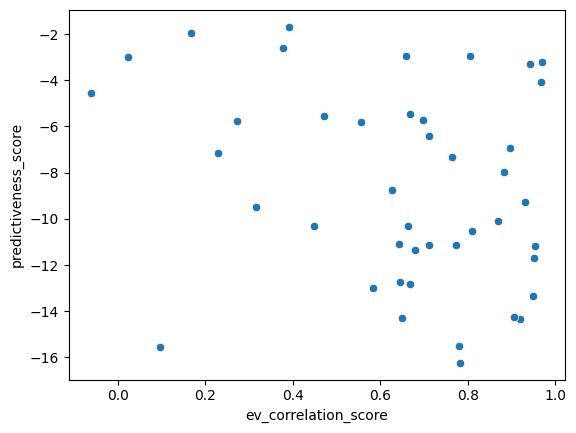

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=score_df["ev_correlation_score"], y=score_df["predictiveness_score"])

In [ ]:
lo, hi

(0.04755272716283798, 0.052709002047777176)

In [ ]:
import torch

toks = """
 1
1.12
 2
1.00
1
0.97
 3
0.95
 4
0.92
 8
0.91
 7
0.90
 6
0.89
 5
0.89
 9
""".split("\n")[1:-1:2]
print(toks)
encodings = tokenizer(toks, return_tensors="pt").input_ids
with torch.inference_mode():
    embeddings = embed(encodings).squeeze(1)
embeddings.shape

[' 1', ' 2', '1', ' 3', ' 4', ' 8', ' 7', ' 6', ' 5', ' 9']


NameError: name 'tokenizer' is not defined

(tensor(0.5440), tensor(0.2241))

In [124]:
layer = 10
fake_dictionary_weight = embed(tokenizer(" 1", return_tensors="pt").input_ids).squeeze() # torch.randn(768)

v = fake_dictionary_weight  # TODO account for layer norm
# for l in range(layer, len(model.transformer.h)):
#     v = model.transformer.h[l].ln_1(v)
#     v = model.transformer.h[l].ln_2(v)
    
assert model.lm_head.bias is None
logit_contributions = model.lm_head.weight.data @ v
topk = logit_contributions.topk(10)
topk, [tokenizer.decode(tok) for tok in topk.indices]

(torch.return_types.topk(
 values=tensor([6.7853, 5.5921, 5.1799, 5.1528, 4.8437, 4.7982, 4.6626, 4.4385, 4.3578,
         4.1862], grad_fn=<TopkBackward0>),
 indices=tensor([352, 362, 513,  16, 657, 604, 642, 718, 767, 807])),
 [' 1', ' 2', ' 3', '1', ' 0', ' 4', ' 5', ' 6', ' 7', ' 8'])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,
          1.,   1.,   0.,   0.,   2.,   0.,   1.,   2.,   1.,   5.,   3.,
         11.,  34.,  90., 170., 170., 127.,  87.,  25.,  13.,   5.,   4.,
          4.,   2.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.33035743, -0.31701479, -0.30367215, -0.29032951, -0.27698687,
        -0.26364422, -0.25030158, -0.23695894, -0.2236163 , -0.21027366,
        -0.19693102, -0.18358837, -0.17024573, -0.15690309, -0.14356045,
        -0.13021781, -0.11687517, -0.10353253, -0.09018988, -0.07684724,
        -0.0635046 , -0.05

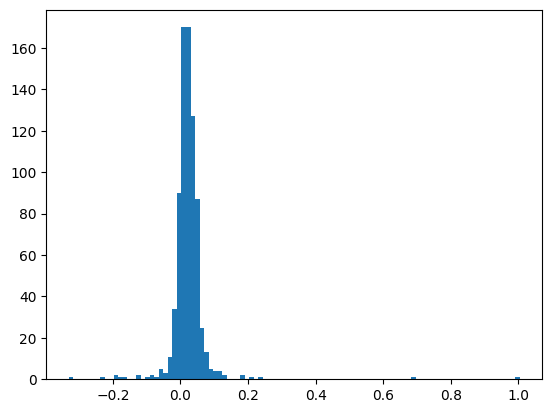

In [123]:
import matplotlib.pyplot as plt

plt.hist(model.transformer.h[l].ln_1.bias.data.tolist(), bins=100)

In [70]:
fake_dictionary_weight.shape

torch.Size([1, 1, 768])

# Output explanation scoring

In [96]:
from transformers import AutoModelForCausalLM, AutoTokenizer

scorer_name = "meta-llama/Meta-Llama-3-8B"
scorer = AutoModelForCausalLM.from_pretrained(scorer_name)
scorer_tokenizer = AutoTokenizer.from_pretrained(scorer_name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [118]:
explanation = "I intervened on a feature that causes the model to use she/her pronouns more."
random_explanation = "I intervened on a feature that causes the model think of things related to mountains more."
null_explanation = "Here is a sentence."
example = "Sally went to the beach."

# scorer_tokenizer.apply_chat_template([{"role": "assistant", "content": f"Explanation:\n{explanation}\n\nExample:\n{example}"}], tokenize=False, add_generation_prompt=False)
def get_scorer_prompt(explanation):
    return f"Explanation:\n{explanation}\n\nExample:\n{example}"

def get_logprobs(text):
    with torch.inference_mode():
        logits = scorer(scorer_tokenizer(text, return_tensors="pt").input_ids).logits[0, -1, :]
    return logits.log_softmax(dim=-1)

top_diff_toks = [" She", " Her"]
top_logodds_diffs = torch.tensor([10.0, 8.0])
top_diff_ids = [scorer_tokenizer.encode(tok, add_special_tokens=False)[0] for tok in top_diff_toks]

def get_explanation_score(explanation):
    logprobs = get_logprobs(get_scorer_prompt(explanation))
    diff_distr = torch.sigmoid(top_logodds_diffs)
    print(diff_distr.sum())
    diff_distr /= diff_distr.sum()
    # get the scorer's logP(next_tok | explanation, prompt) averaged over 
    # the next_toks that were most affected by the intervention 
    # (weighted by the sigmoid(bayes factor) distribution)
    print(logprobs.shape, top_diff_ids)
    logposterior = diff_distr * logprobs[top_diff_ids]
    return logposterior.sum()

get_explanation_score(explanation), get_explanation_score(random_explanation), get_explanation_score(null_explanation)

tensor(1.9996)
torch.Size([128256]) [3005, 6385]
tensor(1.9996)
torch.Size([128256]) [3005, 6385]
tensor(1.9996)
torch.Size([128256]) [3005, 6385]


(tensor(-2.2770), tensor(-3.0543), tensor(-3.0925))